In [ ]:
from timeit import default_timer as time
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

# Data Cleaning&Feature Engineering

In [74]:
# fix data type
df = pd.read_csv('https://raw.githubusercontent.com/Shawn-zou-2020/MyProjects/main/Fraud%20Analysis/Card%20Application%20Fraud%20Analysis/Raw%20Data/applications%20data.csv')
df['date']=pd.to_datetime(df['date'],format='%Y%m%d')
df['zip5']=df['zip5'].apply(lambda x: '{0:0>5}'.format(x))
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,19070626,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,2016-01-01,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0


In [75]:
# fix frivolous values (replace them with values that will not link)
# ssn
df.loc[df.ssn==999999999,'ssn']=-df.loc[df.ssn==999999999]['record']
df['ssn']=df['ssn'].apply(lambda x: '{0:0>9}'.format(x))
df.head(5)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,19070626,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0


In [76]:
# address
df.loc[df.address=='123 MAIN ST','address']=df.loc[df.address=='123 MAIN ST','record'].apply(lambda x: str(x)+'RECORD')

In [77]:
# dob
df.loc[df.dob==19070626,'dob']=-df.loc[df.dob==19070626]['record']
df['dob']=df['dob'].apply(lambda x: '{0:0>8}'.format(x))

In [78]:
# homephone
df.loc[df.homephone==9999999999,'homephone']=-df.loc[df.homephone==9999999999]['record']
df['homephone']=df['homephone'].apply(lambda x: '{0:0>10}'.format(x))

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  int64         
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 76.3+ MB


In [80]:
# Make day of week target encoding
df['dow']=df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [81]:
# get training data
train_test=df[df.date<'2016-11-01']

In [82]:
# smoothing
nmid=20
c=4
y_avg=train_test['fraud_label'].mean()
y_dow=train_test.groupby('dow')['fraud_label'].mean()
num=train_test.groupby('dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
df['dow_risk']=df.dow.map(y_dow_smooth)
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,dow,dow_risk
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0,Friday,0.014499
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,Friday,0.014499
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0,Friday,0.014499
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0,Friday,0.014499
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,Friday,0.014499


In [83]:
y_dow=y_dow.reset_index()
# define sorting order to weekdays
cats=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['dow']=pd.Categorical(y_dow['dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('dow')
y_dow=y_dow.set_index('dow')
y_dow

,fraud_label
dow,
Monday,0.013480
Tuesday,0.014070
Wednesday,0.015169
Thursday,0.014981
Friday,0.014499
Saturday,0.014968
Sunday,0.013674


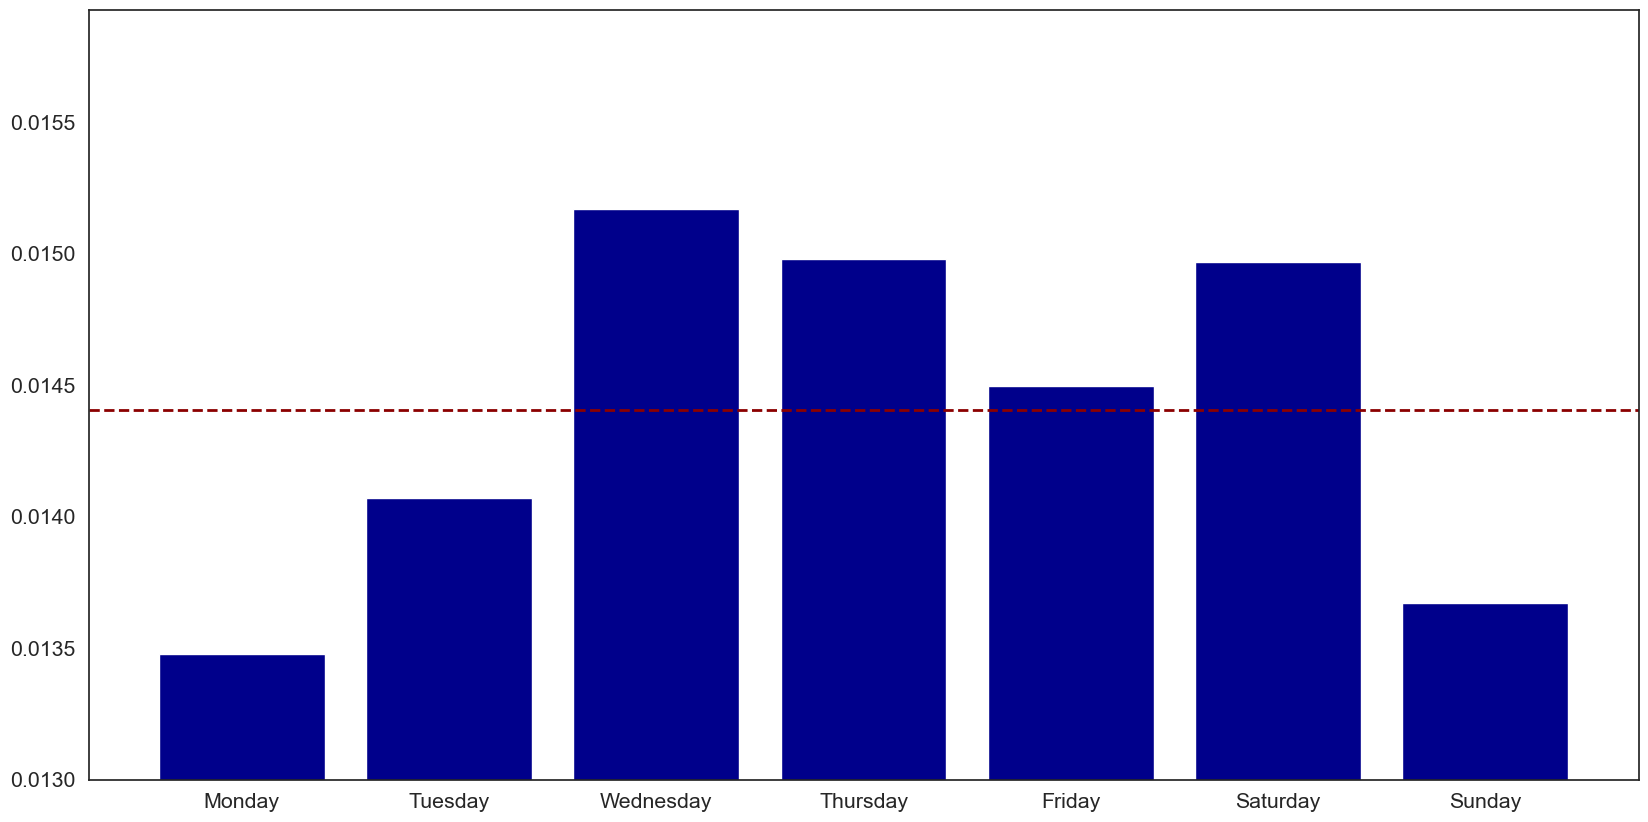

In [84]:
sns.set_style('white')
fig, ax=plt.subplots(figsize=(20,10))
plt.bar(data=y_dow, x=y_dow.index, height=y_dow.fraud_label, color='darkblue')
ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg,ls='--',lw=2,color='darkred')


plt.show()

In [85]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,dow,dow_risk
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0,Friday,0.014499
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,Friday,0.014499
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0,Friday,0.014499
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0,Friday,0.014499
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,Friday,0.014499


In [86]:
df['name']=df.firstname+df.lastname
df['fulladdress']=df.address+df.zip5
df['name_dob']=df.name+df.dob
df['name_fulladdress']=df.name+df.address
df['name_homephone']=df.name+df.homephone
df['fulladdress_dob']=df.fulladdress+df.dob
df['fulladdress_homephone']=df.fulladdress+df.homephone
df['dob_homephone']=df.dob+df.homephone
df['name_homephone_dob']=df.homephone+df.name+df.dob
df['name_fulladdress_dob']=df.fulladdress+df.name+df.dob
for i in list(df.iloc[:,np.r_[3:9,12:20]].columns):
    df['ssn_'+i]=df.ssn+df[i]
len(df.columns)

36

In [87]:
attributes=list(df.iloc[:, np.r_[2,7,8,12:36]].columns)
attributes2=attributes.copy()
attributes.remove('ssn_firstname')
attributes.remove('ssn_lastname')
attributes.remove('ssn_address')
attributes.remove('ssn_zip5')
attributes.remove('dob')
attributes.remove('homephone')
attributes.remove('name')
attributes.remove('fulladdress_homephone')
attributes.remove('ssn_name_homephone')
attributes.remove('name_homephone_dob')
attributes.remove('name_fulladdress_dob')
attributes.remove('ssn_fulladdress_homephone')
attributes.remove('ssn_name_fulladdress')
attributes.remove('ssn_name_dob')
attributes.remove('ssn_fulladdress_dob')
attributes.remove('ssn_dob_homephone')
attributes.remove('fulladdress')
attributes

['ssn',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'dob_homephone',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress']

In [88]:
attributes2

['ssn',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'name_homephone_dob',
 'name_fulladdress_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob',
 'ssn_name_fulladdress',
 'ssn_name_homephone',
 'ssn_fulladdress_dob',
 'ssn_fulladdress_homephone',
 'ssn_dob_homephone']

In [89]:
df1=df.copy()
vars=df.copy()
df1['check_date']=df1.date
df1['check_record']=df1.record
vars.shape

(1000000, 36)

In [90]:
# day since and velocity
for entity in attributes2:
    df_1=df1[['record','date',entity]]
    df_r=df1[['check_record','check_date',entity]]
    temp = pd.merge (df_1, df_r, left_on=entity, right_on=entity)

    # day since
    # days since an application with that entity has been seen. Entities are {include list here}
    day_since_df = temp[temp.record > temp.check_record][['record','date','check_date']].groupby('record')[['date','check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    vars[entity + '_day_since'] = vars.record.map(mapper)
    vars[entity + '_day_since'].fillna(365, inplace=True)

    # velocity
    # applications at that entity over the past n days. Entities are {include list here}, n is {0,1,3,7,14,30}
    for offset_t in [0, 1, 3, 7, 14, 30]:
        count_day_df = temp[(temp.check_date>=(temp.date-dt.timedelta (offset_t)))&(temp.record>=temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        vars[col_name] = vars.record.map(mapper2)

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` man

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_day_since'] = vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name] = vars.record.map(mapper2)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[entity + '_day_since'] = vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1500525628.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [91]:
# relative velocity
for att in attributes2:
    for d in ['0','1']:
        for dd in ['3','7','14','30']:
            vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[att+'_count_'+d+'_by_'+dd]=vars[att+'_count_'+d]/(vars[att+'_count_'+dd]/float(dd))
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/1954251465.py:5: PerformanceWarning

In [92]:
vars.shape

(1000000, 441)

In [93]:
# unique values, entities in particular fields
for e in attributes:
    for f in attributes:
        if e==f:
            continue
        else:
            df_a=df1[['record','date',e]]
            df_b=df1[['check_record','check_date',e,f]]
            temp=pd.merge(df_a,df_b,left_on=e,right_on=e)
        
        # number of unique for particular field
        for ot in [0,1,3,7,14,30]:
            count_day_df=temp[(temp.check_date>=temp.date-dt.timedelta(ot)) & (temp.record>=temp.check_record)]
            col_name=f'{e}_unique_count_for_{f}_{ot}'
            mapper=count_day_df.groupby(['record'])[f].nunique()
            vars[col_name]=vars.record.map(mapper)

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[col_name]=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/2483996824.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [94]:
vars.shape

(1000000, 981)

In [95]:
vars.shape

(1000000, 981)

In [96]:
# day since for entities in particular fields
for e in attributes:
    for f in attributes:
        if e==f:
            continue
        else:
            df_a=df1[['record','date',e]]
            df_b=df1[['check_record','check_date',e,f]]
            temp=pd.merge(df_a,df_b,left_on=e,right_on=e)

        day_since_df=temp[temp.record >temp.check_record][['record','date','check_date']]\
                        .groupby('record')[['date','check_date']].last()
        mapper=(day_since_df.date-day_since_df.check_date).dt.days
        vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
        vars[e+'_for_'+f+'_day_since'].fillna(365,inplace=True)

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vars[e+'_for_'+f+'_day_since']=vars.record.map(mapper)
/var/folders/93/1lgg6hm53495gpcd0fsv6gmh0000gn/T/ipykernel_74327/3075191373.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of 

In [97]:
vars.shape

(1000000, 1071)

In [98]:
vars.to_csv('vars2.csv',index=False)